In [22]:
from cdcqr.data.glassnode import glassnode_data as gnd
from cdcqr.ct.utils import plot2
import pandas as pd
import cdcqr.analytics.utils as autil 
from importlib import reload
pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
import sys
sys.path.append('/core/github/cryptoderiv-quant/')
from ct.alfafactory import runsignal
import numpy as np
import os
from cdcqr.common.utils import LOCAL_DATA_DIR


In [2]:
gn = gnd.GlassnodeData()

### BTC

In [3]:
fs =  ['price_usd_close','FuturesFundingRatePerpetual']
a = ['BTC','ETH']
#i = '10m'
df = gn.load_features(fs,a)
df.head(2)

loading market/price_usd_close asset=BTC, resolution=10m
loading market/price_usd_close asset=ETH, resolution=10m
loading derivatives/futures_funding_rate_perpetual asset=BTC, resolution=10m
loading derivatives/futures_funding_rate_perpetual asset=ETH, resolution=10m


,BTC-price_usd_close,ETH-price_usd_close,BTC-FuturesFundingRatePerpetual,ETH-FuturesFundingRatePerpetual
t,,,,
2010-07-17 23:00:00,0.04951,NaN,NaN,NaN
2010-07-17 23:10:00,NaN,NaN,NaN,NaN


In [4]:
cols = list(df.columns)
cols

['BTC-price_usd_close',
 'ETH-price_usd_close',
 'BTC-FuturesFundingRatePerpetual',
 'ETH-FuturesFundingRatePerpetual']

,BTC-price_usd_close,ETH-price_usd_close,BTC-FuturesFundingRatePerpetual,ETH-FuturesFundingRatePerpetual
t,,,,
2021-01-01 00:00:00,29016.647624,738.475746,0.000039,0.000081
2021-01-01 00:10:00,28866.991978,733.387571,0.000038,0.000079


C:\Users\Wang\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


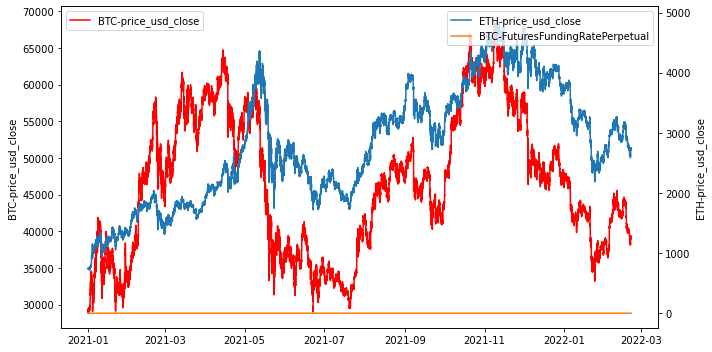

In [5]:
df1 = df[df.index>='20210101']
display(df1.head(2))
df1.plot2(cols[0],cols[1:3])

In [ ]:
reload(autil)
feature_raw = '{}_futures_funding_rate_perpetual'.format(a)
feature_normalized = feature_raw
target = '{}_price_usd_close'.format(a)
_ = autil.ts_eda(df1, feature_raw, feature_normalized, target, save_fig=True)

## backtest

In [13]:
df1.head(5)

,BTC-price_usd_close,ETH-price_usd_close,BTC-FuturesFundingRatePerpetual,ETH-FuturesFundingRatePerpetual,signal
t,,,,,
2021-01-01 00:00:00,29016.647624,738.475746,0.000039,0.000081,NaN
2021-01-01 00:10:00,28866.991978,733.387571,0.000038,0.000079,NaN
2021-01-01 00:20:00,28822.724489,731.379848,0.000037,0.000077,NaN
2021-01-01 00:30:00,28914.266412,733.031648,0.000036,0.000077,NaN
2021-01-01 00:40:00,28955.940660,734.567575,0.000033,0.000079,NaN


In [ ]:
df1['signal'] = df1['BTC-FuturesFundingRatePerpetual'].rolling(200).apply(pctrank)

In [23]:
price = pd.read_pickle(os.path.join(LOCAL_DATA_DIR,'BTC-PERP@ftx.pickle'))
p=price.resample('1Min').last().ffill()
request = ['pf','backtest']

In [24]:
signalid = 'long-funding_rate'
res=[]
price = p.copy()
counter0 = 0
short = False # long strategy
for qtl in [0.995, 0.99, 0.95, 0.9]:
    signal = df1['signal']>qtl
    signal = signal.reindex(p.index).ffill()
    for tp in [3,5,7]:
        for sl in [0.5, 1, 2]:
            counter0 = counter0 + 1
            print(f'{counter0} : tp:{tp} sl:{sl} id:{signalid}')
            for n1 in [1,10,100]: #
                for n2 in [101, 200, 1000]:
                    ressig=runsignal(price,signal=signal,tp=tp,sl=sl,ts=sl,n1=None,n2=None,rsil=30,rsih=50,rsilag=14,maf=5,mas=15,short=short,size=np.inf,fees=0.0007,freq='1Min',init_cash=10000,request=['pf','backtest'])
                    for k in ressig:
                        resd={"signalid":signalid,"qtl":qtl,"short":short,"tp":tp,"sl":sl,'k':k,'sr':ressig[k].sharpe_ratio(),'n1':n1,'n2':n2,'tr':ressig[k].total_return(),'ntrades':ressig[k].trades.count()/65} # rescale to number of weeks
                        res.append(resd)
                            
pd.DataFrame(res).pv()

1 : tp:3 sl:0.5 id:long-funding_rate
2 : tp:3 sl:1 id:long-funding_rate
3 : tp:3 sl:2 id:long-funding_rate
4 : tp:5 sl:0.5 id:long-funding_rate
5 : tp:5 sl:1 id:long-funding_rate
6 : tp:5 sl:2 id:long-funding_rate
7 : tp:7 sl:0.5 id:long-funding_rate
8 : tp:7 sl:1 id:long-funding_rate
9 : tp:7 sl:2 id:long-funding_rate
10 : tp:3 sl:0.5 id:long-funding_rate
11 : tp:3 sl:1 id:long-funding_rate
12 : tp:3 sl:2 id:long-funding_rate
13 : tp:5 sl:0.5 id:long-funding_rate
14 : tp:5 sl:1 id:long-funding_rate
15 : tp:5 sl:2 id:long-funding_rate
16 : tp:7 sl:0.5 id:long-funding_rate
17 : tp:7 sl:1 id:long-funding_rate
18 : tp:7 sl:2 id:long-funding_rate
19 : tp:3 sl:0.5 id:long-funding_rate
20 : tp:3 sl:1 id:long-funding_rate
21 : tp:3 sl:2 id:long-funding_rate
22 : tp:5 sl:0.5 id:long-funding_rate
23 : tp:5 sl:1 id:long-funding_rate
24 : tp:5 sl:2 id:long-funding_rate
25 : tp:7 sl:0.5 id:long-funding_rate
26 : tp:7 sl:1 id:long-funding_rate
27 : tp:7 sl:2 id:long-funding_rate
28 : tp:3 sl:0.5 id

In [ ]:
pd.DataFrame(res).pv()